# Hard sphere dimer LSMC simulations

## Preliminaries

Import the Python packages we'll need, and initialise two simulation boxes with the correct number of chains and beads per chain for the files we'll read. Note that because the model code is written in Fortran internally, replicas, chains and bead indices are 1-based not zero-based. 

In [1]:
import numpy as np  # Numpy
import math as m    # Maths

import hs_alkane as mdl   # Fortran library we'll used to model the alkane chain

In [2]:
Nbeads  = 2    # Dimers
Nchains = 288  # 288 chains in input00[0-1].xmol

# The configurations we'll read have a bond length of L=0.5
mdl.alkane_set_bondlength(0.5)

# Initialise the simulation box and alkane module ready to hold chains
mdl.box_set_num_boxes(2)
mdl.box_initialise()             
mdl.alkane_set_nbeads(Nbeads)    
mdl.alkane_set_nchains(Nchains)  
mdl.alkane_initialise() 

# By default we have periodic boundary conditions, and the example below benefits from using link cells
# to speed up computation. These can be disabled (and will be automatically if the system is too small for them)
# or we can specify that we want to use a Verlet neighbour list instead. If using the neighbour list then we 
# need to make sure if is updated appropriately after moving beads around, but for a mostly static crystal that
# isn't necessary.
#mdl.box_set_bypass_link_cells(1)
#mdl.box_set_use_verlet_list(1)


|=======================================|
| Initialised   1 simulation box(es)    |
| Cell vectors have been reset.         |
|=======================================|


|=======================================|
| Initialised   2 simulation box(es)    |
| Cell vectors have been reset.         |
|=======================================|


|=======================================|
| Initialised   288 chains              |
| Beads per chain :     2               |
| Bead positions have been reset.       |
|=======================================|



## Read initial configurations from xmol files in current working directory

This needs to contain the correct number of beads to match Nchains and Nbeads as defined above. The second line in the xmol file should contain the three cell vectors as illustrated below. Positions 1-2 are for the first dimer, position 3-4 the second, and so on.

In [3]:
!head chain.xmol.0001

576
    4.16272748269267 0.0 0.0 0.0 5.404029570226723 0.0 0.0 0.0 16.15999248657107
C   -2.04990920 -2.69610582 -8.05304547
C   -2.04942884 -2.81173852 -7.56660036
C   -1.56765690 -1.78948556 -8.05717295
C   -1.59598892 -1.89605599 -7.56948448
C   -2.07697161 -1.61412707 -6.72414779
C   -2.07291455 -1.70395491 -6.23229974
C   -1.52950397 -2.58058694 -6.73067302
C   -1.60381490 -2.62098790 -6.23787930


In [4]:
# Read from chain.xmol
mdl.io_read_xmol()               # Read from chain.xmol

 hmatrix   4.1627274826926701        0.0000000000000000        0.0000000000000000        0.0000000000000000        5.4040295702267231        0.0000000000000000        0.0000000000000000        0.0000000000000000        16.159992486571070        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000     
 dot prods   4.1627274826926701        5.4040295702267231        16.159992486571070      link cell length   1.5000000000000000     
 hmatrix   4.1627274826926701        0.0000000000000000        0.0000000000000000        0.0000000000000000        5.4040295702267231        0.0000000000000000        0.0000000000000000        0.0000000000000000        16.159992486571070        4.1607259631802229        0.0000000000000000        0.0000000000000000        0.0000000000000000        5.4046861074273727        0.00000000000000

system too small for link cells of this length    2    3   10
system too small for link cells of this length    2    3   10


In [5]:
# Construct neighbour lists if we can (too small for link cells in this example)
for ibox in range(2) : mdl.alkane_construct_neighbour_list(ibox+1) 

!=======================================!
! This compiler stores .true. as :     1!
!=======================================!
Neighbour list constructed in :        0.004000 seconds
Neighbour list constructed in :        0.004000 seconds


### Sanity check initial configuration

Functions are provided to check that the configuration obeys the model constraints on bond length. We also check that no beads overlap, other than those which are allowed to in the model, e.g. the two beads within a dimer.

In [6]:
# Loop over chains and sanity check configuration
for ibox in range(2):
    for ichain in range(0, Nchains):
    
        # Checks if internal geometry of chain (bonds/angles) are consistent with the model
        geom_flag = mdl.alkane_check_chain_geometry(ichain+1, ibox+1)
        if geom_flag != 0:
            print("Incorrect geometry for chain ",ichain," in box ",ibox+1)
       
    
    # Checks if beads on any two chains overlap
    overlap_flag = mdl.alkane_check_chain_overlap(ibox+1)
    if overlap_flag != 0:
        print("Overlaps between chains in configuration")
    else:
        print("No overlaps between chains found in configuration")  

No overlaps between chains found in configuration
No overlaps between chains found in configuration


## Monte Carlo loop

We will use translation and rotation moves only.

In [7]:
from scipy.linalg import eig # For eigenvalue calculation   

# Initialize TMMC collection matrix
def create_tmmc_collection_matrix(mu_min, mu_max, n_bins):
    """Create a Transition Matrix Monte Carlo collection matrix."""
    n_states = n_bins
    C = np.zeros((n_states, n_states))
    mu_values = np.linspace(mu_min, mu_max, n_bins+1)
    return C, mu_values

# Convert ls_mu to bin index
def mu_to_bin(mu, mu_min, mu_max, n_bins):
    """Convert overlap parameter mu to bin index."""
    if mu < mu_min or mu >= mu_max:
        raise ValueError("mu out of range")
    bin_width = (mu_max - mu_min) / n_bins
    bin_index = int((mu - mu_min) / bin_width)
    return bin_index

def TMMC_bias(collection_matrix):
    """Calculate biasing weights from TMMC collection matrix."""

    Tnorm = np.copy(collection_matrix)
    n_bins = collection_matrix.shape[0]

    # Normalise TMMC collection matrix
    for i in range(n_bins):
        row_sum = np.sum(Tnorm[i, :])
        if row_sum > 0:
            Tnorm[i, :] /= row_sum

    # Compute left eigenvalues and eigenvectors
    eigenvalues, left_eigenvectors = eig(Tnorm, left=True, right=False)

    # Identify dominant eigenvalue
    dominant_index = np.argmax(np.real(eigenvalues))
    #print("Dominant eigenvalue: ", eigenvalues[dominant_index])

    # extract and normalise the dominant left eigenvector
    left_eigenvector = np.real(left_eigenvectors[:, dominant_index])

    # take abs value to avoid negative entries
    left_eigenvector = np.abs(left_eigenvector)

    # If there are zero entries
    if np.any(left_eigenvector == 0):
        min_positive = np.min(left_eigenvector[left_eigenvector > 0])
        left_eigenvector[left_eigenvector == 0] = min_positive

    left_eigenvector /= np.sum(left_eigenvector)

    # Construct biasing potential from dominant eigenvector
    bias_potential = np.log(left_eigenvector) 

    # Shift bias potential to have minimum at zero
    bias_potential -= np.min(bias_potential)    

    return bias_potential


In [ ]:
import matplotlib.pyplot as plt  # For plotting

# For progress bar
from ipywidgets import IntProgress
from IPython.display import display

# Move types
move_types = ['box', 'translate', 'rotate']
ivol = 0; itrans = 1; irot = 2; 
moves_attempted = np.zeros(3, dtype=int)
moves_accepted  = np.zeros(3, dtype=int)

# Set move sizes
mdl.alkane_set_dr_max(0.012)    # Max translation move
mdl.alkane_set_dt_max(0.10)    # Max rotation move (radians)

# Active and passive lattice
lsl = (2, 1)
ls = 1             # Active lattice
lsn = lsl[ls-1]    # Passive lattice

# Initialise counters
Nsweeps = 60_000
isweep = 0

# Initialise LSMC overlap parameter
# This is overlaps(1) - overlaps(2)
ls_sign = (1, -1)
ls_mu = 0

# Create progress bar
f = IntProgress(min=0, max=Nsweeps) 
display(f) # display the bar

# How often to sample quantities
sample_interval = 10
samples = list()

# If we can't use link cells try using Verlet neighbour list
mdl.box_set_use_verlet_list(1) 
mdl.alkane_construct_neighbour_list(1)
mdl.alkane_construct_neighbour_list(2)

# Initialise TMMC collection matrix
mu_min = -750
mu_max = +750
n_bins = 1500
TMMC_coll, mu_values = create_tmmc_collection_matrix(mu_min, mu_max, n_bins)

# Initialise bias potential at zero
TMMC_bias_potential = np.zeros(n_bins)

# Initiase hisogram of visited states
histogram_visited = np.zeros(n_bins, dtype=int)

# How often to update bias potential once TMMC is active
bias_update_int = 100

# TMMC active
TMMC_active = False

# WL modification factor
fmod = 0.5

# Load previous TMMC bias potential if available and of right shape
try:
    data = np.load("TMMC_bias_potential.npz")
    loaded_bias = data['arr_0']
    if loaded_bias.shape == TMMC_bias_potential.shape:
        TMMC_bias_potential = loaded_bias
        print("Loaded previous TMMC bias potential from file.")
    else:
        print("Previous TMMC bias potential has incorrect shape, ignoring.")    
except FileNotFoundError:
    print("No previous TMMC bias potential file found, starting fresh.")

# Load previous TMMC collection matrix if available and of right shape
try:
    data = np.load("TMMC_collection_matrix.npz")
    loaded_coll = data['arr_0']
    if loaded_coll.shape == TMMC_coll.shape:
        TMMC_coll = loaded_coll
        print("Loaded previous TMMC collection matrix from file.")
    else:
        print("Previous TMMC collection matrix has incorrect shape, ignoring.")    
except FileNotFoundError:
    print("No previous TMMC collection matrix file found, starting fresh.")

# Load previous TMMC_active state if available
#try:
#    data = np.load("TMMC_active_state.npz")
#    loaded_active = data['arr_0']
#    TMMC_active = bool(loaded_active)
#    print("Loaded previous TMMC_active state from file: ", TMMC_active)
#except FileNotFoundError:
#    print("No previous TMMC_active_state file found, assuming inactive.")

# Load previous WL modification factor if available
try:
    data = np.load("WL_modification_factor.npz")
    loaded_fmod = data['arr_0']
    fmod = float(loaded_fmod)
    print("Loaded previous WL modification factor from file: ", fmod)
except FileNotFoundError:
    print("No previous WL modification factor file found, using default.")

# Load histogram of visited states for WL
try:
    data = np.load("TMMC_visited_histogram.npz")
    loaded_hist = data['arr_0']
    if loaded_hist.shape == histogram_visited.shape:
        histogram_visited = loaded_hist
        print("Loaded previous histogram of visited states from file.")
    else:
        print("Previous histogram of visited states has incorrect shape, ignoring.")    
except FileNotFoundError:
    print("No previous histogram of visited states file found, starting fresh.")    


# Initialise timer
t1 = mdl.timer_init()

# Loop over the number of MC sweeps to perform
while isweep < Nsweeps:
    
    # One "sweep" is usually interpretted as one attempt to change each degree of freedom on average once.
    # here we have 3 translation + 2 rotation degrees of freedom per chain, plus 6 degrees
    # of freedom for the simulation cell (ignoring rotations of the box).
    
    # A chain translation move changes 3 degrees of freedom
    # A chain rotation move changes 2 degrees of freedom
    
    # Hence if we attempt each move type with a probability proportional to the number of degrees
    # of freedom it changes, we need to do 2*Nchains+6 moves to get one "sweep". Sampling in this
    # ratio isn't necessarily optimal, but it's a good starting point.
    
    # Calculate cumulative move ratios used to decide move type
    total_deg = 5*Nchains #+6

    #box_move_prob   = 6.0/total_deg
    trans_move_prob = 3.0*Nchains/total_deg # box_move_prob   
    rot_move_prob   = trans_move_prob + 2.0*Nchains/total_deg

    # Loop over move attempts at the current sweep
    imove = 0
    while imove < total_deg:

        #==========================#
        # Make a random trial move #
        #==========================#
        
        # Pick a random chain numbered from 0 to Nchains
        ichain = np.random.randint(0, high=Nchains)

        # Backup old chain positions. Note that whenever we call a routine inside the
        # hs_alkane library we need to add one to the bead/chain index to account for
        # Fortran indexing. 
        current_active_chain = mdl.alkane_get_chain(ichain+1, ls)
        backup_active_chain = current_active_chain.copy() # Note copy, not equivalence

        current_passive_chain = mdl.alkane_get_chain(ichain+1, lsn)
        backup_passive_chain = current_passive_chain.copy() # Note copy, not equivalence

        # Overlap count before move in passive lattice
        n_overlaps_passive_before = mdl.alkane_chain_count_overlaps(ichain+1, lsn)
        #print("Chain ", ichain, " has ", n_overlaps_passive_before, " overlaps in passive lattice before move.")

        # Bias potential before move
        mu_bin_before = mu_to_bin(ls_mu, mu_min, mu_max, n_bins)
        bias_before = TMMC_bias_potential[mu_bin_before]

        # Pick a move type at random and call the appropriate function to make that 
        # trial move and return the corresponding ratio of Boltzmann factors.
        xi = np.random.random()
        #if xi < box_move_prob:
        #    # Attempt a volume move
        #    itype = ivol
        #    boltz = mdl.alkane_box_resize(pressure, ibox, 0) # 0 here indicates not a box reset
        if xi < trans_move_prob:

            # Attempt a translation move
            itype = itrans
            boltz, move = mdl.alkane_translate_chain(ichain+1, ls)

            # Make the same move in the passive lattice 
            # NOTE: if doing NPT this should be the same move in fractional/scaled coordinates
            for ibead in range(Nbeads):
                current_passive_chain[ibead] += move

        elif xi < rot_move_prob:

            # Attempt a rotation move
            itype = irot
            boltz, quat = mdl.alkane_rotate_chain(ichain+1, ls, 0) # Rotate type 0 (not about a bond)

            # Make the same rotation in the passive lattice
            for ibead in range(Nbeads):
                rbead = current_passive_chain[ibead] - current_passive_chain[0]
                rbead_rot = mdl.quat_conjugate_q_with_v(quat, rbead)
                current_passive_chain[ibead] = rbead_rot + current_passive_chain[0]

        
        # Increment attempted move counter
        moves_attempted[itype] += 1

        # Change in overlaps in passive lattice due to move
        n_overlaps_passive_after = mdl.alkane_chain_count_overlaps(ichain+1, lsn)
        #print("Chain ", ichain, " has ", n_overlaps_passive_after, " overlaps in passive lattice after move.")
        delta_overlaps = n_overlaps_passive_after - n_overlaps_passive_before

        try:
            
            # Update TMMC collection matrix
            mu_bin_after = mu_to_bin(ls_mu + ls_sign[lsn-1]*delta_overlaps, mu_min, mu_max, n_bins)
            TMMC_coll[mu_bin_before, mu_bin_after] += boltz

            # Always update diagonal regardless
            mu_bin_before = mu_to_bin(ls_mu, mu_min, mu_max, n_bins)
            TMMC_coll[mu_bin_before, mu_bin_before] += 1.0 - boltz

        except (IndexError, ValueError):
            
            #TMMC_coll[mu_bin_before, mu_bin_before] += 1.0 # Cannot leave
            pass # mu out of range, ignore this move for TMMC purposes

        #Bias potential after move
        try:
            mu_bin_after = mu_to_bin(ls_mu + ls_sign[lsn-1]*delta_overlaps, mu_min, mu_max, n_bins)
            bias_after = TMMC_bias_potential[mu_bin_after]
        except (IndexError, ValueError):
            #print("mu out of range after move")
            #print( "ls_mu: ", ls_mu, " delta_overlaps: ", delta_overlaps)
            #print( "mu_bin_after: ", mu_bin_after)
            bias_after = np.finfo(float).max # mu out of range, set bias to a large number

        # Update Boltzmann factor with biasing weights
        if (bias_after > bias_before):
            boltz = boltz * m.exp( - (bias_after -  bias_before) )
        #if boltz < 1.0 and boltz > 0.0:
        #    print("Move type ", move_types[itype], " boltzmann factor with bias: ", boltz)
                              
        #====================#
        # Accept/reject move #
        #====================#
        
        # Reject according to Metropolis criterion
        if (np.random.random() < boltz):
            
            # Move accepted
            moves_accepted[itype] += 1
            
            # Update linked-list for new positions if not volume move. This isn't strictly
            # necessary for a perfect solid where all beads will remain in (or very near) their initial
            # link cell, but would be absolutely necessary for a fluid.
            #if (itype!=ivol):
            #    for ibead in range(Nbeads):
            #        mdl.alkane_update_linked_lists(ibead+1, ichain+1, ibox, backup_active_chain[ibead], current_active_chain[ibead])
            #        mdl.alkane_update_linked_lists(ibead+1, ichain+1, ibox, backup_passive_chain[ibead], current_passive_chain[ibead])


            ls_mu = ls_mu + ls_sign[lsn-1]*delta_overlaps

        else:
            
            # Reject move
            if (itype!=ivol):
                # Restore old chain if single chain move
                for ibead in range(Nbeads):
                    current_active_chain[ibead] = backup_active_chain[ibead]
                    current_passive_chain[ibead] = backup_passive_chain[ibead]

            #else:
                # Reset the box change - special fucntion for this.
            #    dumboltz = mdl.alkane_box_resize(pressure, ibox, 1) # 1 here indicates reset to previous box

        imove += 1

        # Attempt a lattice switch move after every move
        if ls_mu == 0:
            
            # Perform lattice switch
            ls_old = ls
            lsn_old = lsn
            ls = lsn_old
            lsn = ls_old

        if not TMMC_active:

            # Bias away from visited states
            TMMC_bias_potential[mu_to_bin(ls_mu, mu_min, mu_max, n_bins)] += fmod

            # Update histogram of visited states
            histogram_visited[mu_to_bin(ls_mu, mu_min, mu_max, n_bins)] += 1

    if isweep % bias_update_int == 0:

        # If smallest histogram count is more than 0.8 of the mean, reduce fmod
        mean_count = np.mean(histogram_visited)
        min_count = np.min(histogram_visited)
        if min_count > 0.8 * mean_count and min_count > 0:
            fmod *= 0.5
            print("Reducing WL modification factor to: ", fmod)

    #    if TMMC_active:

    #        # Construct bias from transition matrix
    #        TMMC_bias_potential = TMMC_bias(TMMC_coll)

    #    else:

    #        # Activate TMMC if collection matrix has non zero entries in all rows
    #        row_sums = np.sum(TMMC_coll, axis=1)
    #        if np.all(row_sums > 0):
    #            TMMC_active = True
    #            print("Activating TMMC at sweep ", isweep)

    # Sample 
    if isweep%sample_interval == 0:
        samples.append(ls_mu)

    # Update bias potential from TMMC collection matrix every 100 sweeps
    #if isweep%bias_update_int == 0 and isweep > 0:
    #    TMMC_bias_potential = TMMC_bias(TMMC_coll)
    #    print(ls_mu)

        # debugging : print the sum of the collection matrix
        #print("Sum of TMMC collection matrix at sweep ", isweep, " is ", np.sum(TMMC_coll))

        # debugging : print the sum of the bias potential
        #print("Sum of TMMC bias potential at sweep ", isweep, " is ", np.sum(TMMC_bias_potential))

        # Debug print highest bin for which the bias in larger than 1
        #for ibin in range(n_bins-1, -1, -1):
        #    if TMMC_bias_potential[ibin] > 1.0:
        #        print("At sweep ", isweep, " highest bin with bias > 1.0 is ", ibin)
        #        break

        #if isweep % (10*bias_update_int) == 0:
        
            #bin_width = (mu_max - mu_min) / n_bins
            #mu_centers = mu_values[:-1] + bin_width/2

            # Plot current bias potential every 1000 sweeps
            #plt.plot(mu_centers, TMMC_bias_potential)
            #plt.xlabel('LSMC overlap parameter')
            #plt.ylabel('Bias potential')
            #plt.title('TMMC Bias potential at sweep '+str(isweep))
            #plt.show()

    
    # Increment sweep counter and progress bar
    isweep += 1
    f.value += 1
    
    
# Timing
print("Completed ",Nsweeps," sweeps in ",mdl.timer_elapsed_time()," seconds.")
    
# Report statistics
for itype in (1,2):
    percent = 100.0 * moves_accepted[itype]/moves_attempted[itype]
    print("Accepted ",percent," % of ", moves_attempted[itype], move_types[itype]," moves")

print("Current LSMC overlap parameter: ", ls_mu)


# Save current TMMC bias potential using np.savez
np.savez("TMMC_bias_potential.npz", TMMC_bias_potential)

# Save current TMMC collection matrix
np.savez("TMMC_collection_matrix.npz", TMMC_coll)

# Save TMMC_active state
#np.savez("TMMC_active_state.npz", TMMC_active) 

# Save fmod
np.savez("WL_modification_factor.npz", fmod)

# Save current histogram of visited states
np.savez("TMMC_visited_histogram.npz", histogram_visited)


IntProgress(value=0, max=60000)

Neighbour list constructed in :        0.006000 seconds
Neighbour list constructed in :        0.003000 seconds
Loaded previous TMMC bias potential from file.
Loaded previous TMMC collection matrix from file.
Loaded previous WL modification factor from file:  0.5

| Timer initialised |

Completed  60000  sweeps in  950.8099999999977  seconds.
Accepted  3.3402802882833558  % of  51829423 translate  moves
Accepted  4.021275086036313  % of  34570577 rotate  moves
Current LSMC overlap parameter:  44


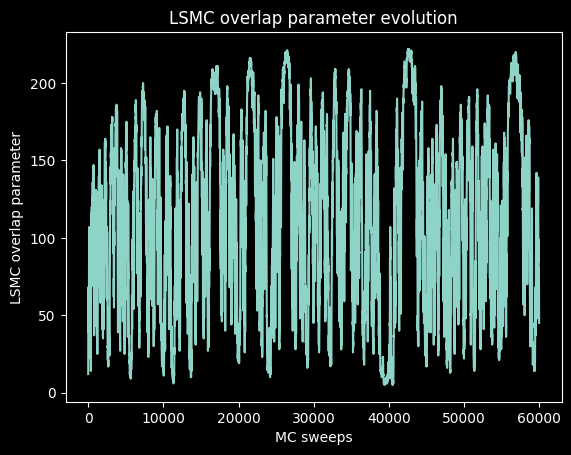

In [19]:
# Plot LSMC overlap parameter evolution
import matplotlib.pyplot as plt # For plotting

plt.plot(np.arange(0, len(samples))*sample_interval, samples)
plt.xlabel('MC sweeps')
plt.ylabel('LSMC overlap parameter')
plt.title('LSMC overlap parameter evolution')
plt.show()  

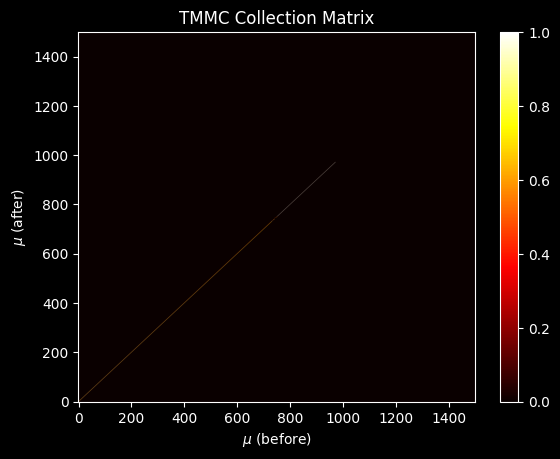

In [20]:
# Normalise TMMC collection matrix
for i in range(n_bins):
    row_sum = np.sum(TMMC_coll[i, :])
    if row_sum > 0:
        TMMC_coll[i, :] /= row_sum

# Visualise TMMC collection matrix
# --- IGNORE ---
import matplotlib.pyplot as plt

plt.imshow(TMMC_coll, origin='lower', aspect='auto', cmap='hot')
plt.colorbar()
plt.xlabel(r'$\mu$ (before)')
plt.ylabel(r'$\mu$ (after)')
plt.title('TMMC Collection Matrix')
plt.show()

Eigenvalues (real parts) in decreasing order:
0.9999999999999984
0.9999999999999978
0.9996200520741172
0.9993737127886333
0.999234731150848


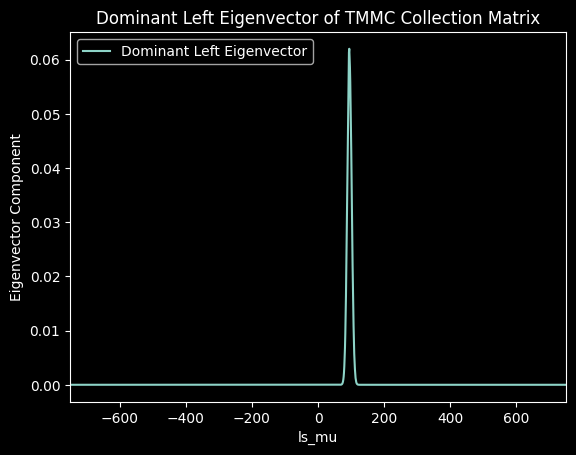

In [21]:
# Find and plot the dominant left eigenvector of the TMMC collection matrix
from scipy.linalg import eig 

eigenvalues, left_eigenvectors = eig(TMMC_coll, left=True, right=False)

# Print the first few eigenvalues in order of decreasing real part
sorted_indices = np.argsort(np.real(eigenvalues))[::-1]
print("Eigenvalues (real parts) in decreasing order:")
for idx in sorted_indices[:5]:
    print(np.real(eigenvalues[idx]))    

# Print the dominant eigenvalue
dominant_index = np.argmax(np.real(eigenvalues))

left_eigenvector = np.real(left_eigenvectors[:, dominant_index])

# take abs value to avoid negative entries
left_eigenvector = np.abs(left_eigenvector)

# If there are zero entries
if np.any(left_eigenvector == 0):
    min_positive = np.min(left_eigenvector[left_eigenvector > 0])
    left_eigenvector[left_eigenvector == 0] = min_positive

left_eigenvector /= np.sum(left_eigenvector)



bin_width = (mu_max - mu_min) / n_bins
mu_centers = mu_values[:-1] + bin_width/2

# Do the same for the eigenvector with the second largest eigenvalue
second_index = np.argsort(np.real(eigenvalues))[-2]
   

# extract and normalise the second left eigenvector
second_left_eigenvector = np.real(left_eigenvectors[:, second_index])
second_left_eigenvector /= np.sum(second_left_eigenvector)  

# --- IGNORE ---
import matplotlib.pyplot as plt


plt.plot(mu_centers, left_eigenvector/(bin_width), label='Dominant Left Eigenvector')
#plt.plot(mu_centers, second_left_eigenvector/(bin_width), label='Second Left Eigenvector')
#plt.hist(samples, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
#plt.yscale('log')
plt.xlabel('ls_mu')
plt.xlim(mu_min, mu_max)
plt.ylabel('Eigenvector Component')
plt.title('Dominant Left Eigenvector of TMMC Collection Matrix')
plt.legend()
plt.show()

6.589206501348942e-172
-2.7809702642798415


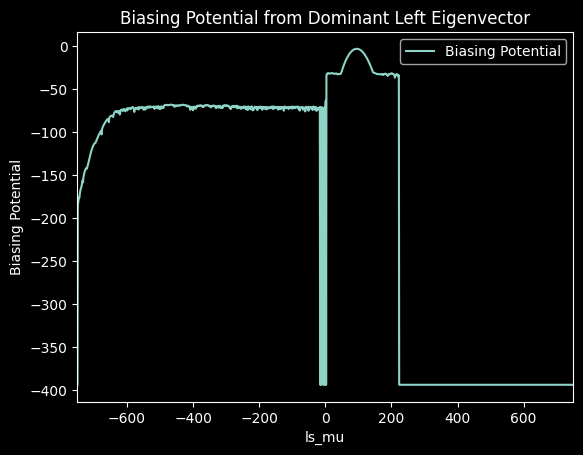

In [22]:
# Construct biasing potential from dominant eigenvector

# Smallest positive value in left_eigenvector
min_value = np.min(left_eigenvector[left_eigenvector > 0])
print(min_value)
bias_potential = [ np.log(x) if x > 0 else min_value for x in left_eigenvector]
print(np.max(bias_potential))

# Shift bias potential to have minimum at zero
#bias_potential -= np.min(bias_potential)    

# Plot biasing potential
plt.plot(mu_centers, bias_potential, label='Biasing Potential')
plt.xlabel('ls_mu')
plt.xlim(mu_min, mu_max)
plt.ylabel('Biasing Potential')
plt.title('Biasing Potential from Dominant Left Eigenvector')
plt.legend()
plt.show()


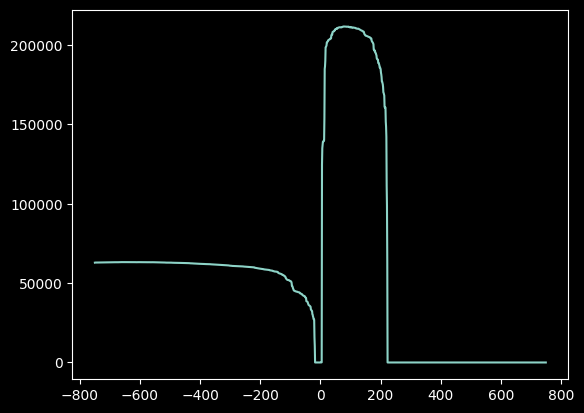

In [23]:
# Plot TMMC bias potential
# --- IGNORE ---
import matplotlib.pyplot as plt # For plotting 
plt.plot(mu_centers, TMMC_bias_potential)